In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45309,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40403,Total threads: 1
Dashboard: /proxy/37643/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:40211,


2025-07-31 11:47:07,819 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('concatenate-96d48203fd7b500b38969bd3a3aba9c3', 41, 0, 1, 10) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('concatenate-96d48203fd7b500b38969bd3a3aba9c3', 41, 0, 1, 10)->('where-concatenate-96d48203fd7b500b38969bd3a3aba9c3', 41, 0, 1, 10))
new run_spec: Alias(('concatenate-96d48203fd7b500b38969bd3a3aba9c3', 41, 0, 1, 10)->('where-f334e198ebfe12cd35224de425491f67', 0, 0, 1, 10))
old dependencies: {('where-concatenate-96d48203fd7b500b38969bd3a3aba9c3', 41, 0, 1, 10)}
new dependencies: {('where-f334e198ebfe12cd35224de42

In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/*/*ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

In [4]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [5]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [6]:
def preprocess(ds):
    ds = ds[['thetao', 'so']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
# Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [8]:
import gsw

In [9]:
#### Calculatin

In [11]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [12]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [13]:
tempC = tempC.astype('float32')
tempM = tempM.astype('float32')
tempM

<xarray.DataArray 'CT' (time: 120, z_l: 75, yh: 1066, xh: 7200)> Size: 276GB
dask.array<astype, shape=(120, 75, 1066, 7200), dtype=float32, chunksize=(2, 75, 338, 400), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          °C
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [15]:
saltC = cont['so']
saltM = melt['so']

In [16]:
temp_anom = tempM - tempC
salt_anom = saltM - saltC

In [17]:
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['areacello']
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello']

# Correcting the area
var_C = cont['so'].isel(time=0,z_l=0)
var_M = melt['so'].isel(time=0,z_l=0)

# Correcting area
areaC_corr = areaC*(var_C*0 +1)
areaM_corr = areaM*(var_M*0 +1)

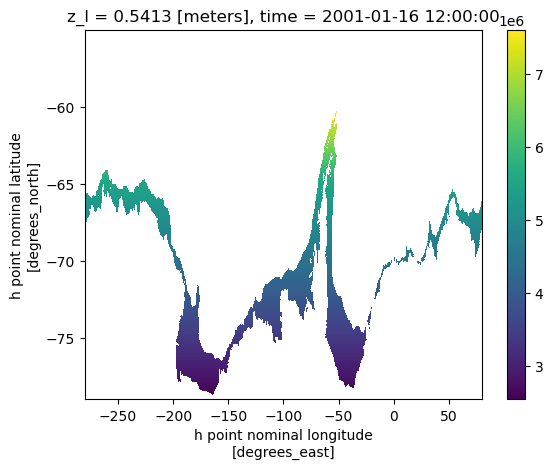

In [18]:
areaC_corr.plot()

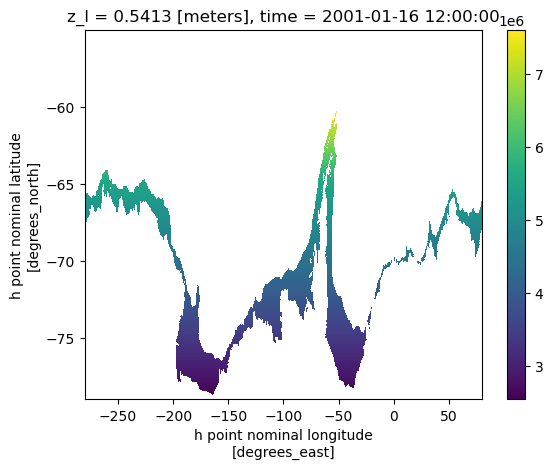

In [19]:
areaM_corr.plot()

In [20]:
# Taking the sum - control and melt areas are the same so only using control here.
shelf_area = areaC_corr.where(shelf_mask == 1).cf.sum({'longitude', 'latitude'}).load()

In [21]:
temp_hov = (areaC_corr * temp_anom).cf.sum({'longitude', 'latitude'}) / shelf_area
salt_hov = (areaC_corr * salt_anom).cf.sum({'longitude', 'latitude'}) / shelf_area
temp_hov

<xarray.DataArray (time: 120, z_l: 75)> Size: 36kB
dask.array<truediv, shape=(120, 75), dtype=float32, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [22]:
temp_hov = temp_hov.load()

2025-07-31 11:20:57,787 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:32843
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^

In [23]:
salt_hov = salt_hov.load()

2025-07-31 12:02:32,172 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:42863 -> tcp://127.0.0.1:35243
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [24]:
def plot_hovmoller_shelf(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize=(10, 9))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63])]
    
    for i in range(len(ax)):
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

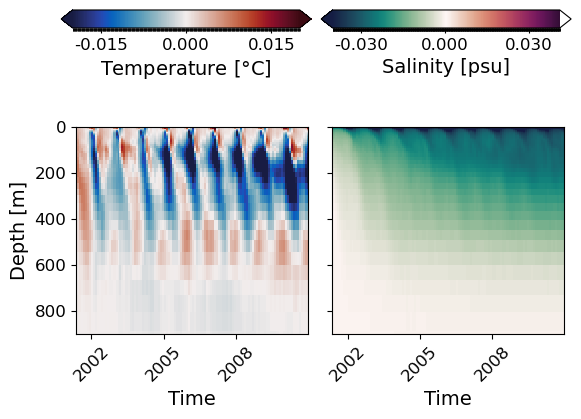

In [25]:
#Shelf area plot

fig, ax = plot_hovmoller_shelf(fsize = 14)

levels_temperature = np.arange(-0.02, 0.0201, 0.0001)

cf_temp = temp_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

levels_salinity = np.arange(-0.04, 0.041, 0.0001)

cf_salt = salt_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_xlabel("Time")
        ax[i].set_ylim(900, 0)
        ax[i].set_xlim(500,4000)
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 900)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()

In [26]:
temp_hov.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/hov_temp_pan005.nc')
salt_hov.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/salt_temp_pan005.nc')